# 1. 사전 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

%cd "/content/drive/MyDrive/Colab_Notebooks/"

# !git clone https://github.com/guillaumejs2403/ACE.git

workstation = "/content/drive/MyDrive/Colab_Notebooks/ACE/"
%cd $workstation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks
/content/drive/MyDrive/Colab_Notebooks/ACE


In [ ]:
import os
from PIL import Image
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

%pip install mpi4py pyyaml h5py git-lfs


- Smiling: \{1, -1\}
    - 1: 웃음
    - -1: 웃지 않음
- Young: \{1, -1\}
    - 1: 젊음
    - -1: 젊지 않음

# 2. DDPM 모델, Classifier 가중치 가져오기

## Diffusion 모델 가져오기

In [ ]:
# !wget https://huggingface.co/guillaumejs2403/ACE/blob/main/bdd-diffusion.pt
# !wget https://huggingface.co/guillaumejs2403/ACE/resolve/main/celebahq-ddpm.pt
# !wget https://github.com/valeoai/STEEX/releases/download/v.0.1/checkpoints_decision_densenet.tar.gz

## Classifier 가중치 가져오기

In [ ]:
# # decision densnet의 가중치 다운받아서 torch로 로드
# !wget https://github.com/valeoai/STEEX/releases/download/v.0.1/checkpoints_decision_densenet.tar.gz
# !tar -zxvf checkpoints_decision_densenet.tar.gz


# 데이터셋 가져오기
- CelebA dataset(kaggle)
- CelebAMask-HQ(kaggle)

In [ ]:
# # Kaggle: celeba-dataset 다운로드 후 /content/celeba-dataset/에 압축 해제
# !curl -L -o /content/celeba-dataset.zip\
#   https://www.kaggle.com/api/v1/datasets/download/jessicali9530/celeba-dataset
# !unzip /content/celeba-dataset.zip -d /content/celeba-dataset

# # Kaggle: celebamaskhq 다운로드 후 /content/celebamaskhq_dataset/에 압축 해제
# !curl -L -o /content/celebamaskhq.zip\
#   https://www.kaggle.com/api/v1/datasets/download/ipythonx/celebamaskhq
# !unzip /content/celebamaskhq.zip -d /content/celebahqmask_dataset

# !cp /content/celeba-dataset/list_eval_partition.csv /content/celebahqmask_dataset/CelebAMask-HQ/

## 각 데이터셋별 이미지 확인

In [ ]:
celeba_dir = "/content/celeba-dataset/img_align_celeba/img_align_celeba/"
celeba_img = os.listdir(celeba_dir)

celebamhq_dir = "/content/celebahqmask_dataset/CelebAMask-HQ/CelebA-HQ-img/"
celebamhq_img = os.listdir(celebamhq_dir)

idx = np.random.randint(0, len(celebamhq_img))

print(f"""[CelebA]
이미지 크기:  {Image.open(celeba_dir+celeba_img[idx]).size} \t 이미지 개수: {len(celeba_img)}""")
print(f"""[CelebAMasked-HQ]
이미지 크기:  {Image.open(celebamhq_dir+celebamhq_img[idx]).size} \t 이미지 개수: {len(celebamhq_img)}""")

FileNotFoundError: [Errno 2] No such file or directory: '/content/celeba-dataset/img_align_celeba/img_align_celeba/'

In [ ]:
print("CelebA")
Image.open(celeba_dir+celeba_img[idx]).resize((128, 128))

CelebA


NameError: name 'celeba_img' is not defined

In [ ]:
print("CelebAMask-HQ")
Image.open(celebamhq_dir+celebamhq_img[idx]).resize((256, 256))

CelebAMask-HQ


NameError: name 'celebamhq_dir' is not defined

In [ ]:
%cd $workstation

/content/drive/MyDrive/Colab_Notebooks/ACE


In [ ]:
%ls

ACE_CCKSY.ipynb                         compute_SimSiamSimilarity.py
ACE_백업/                               core/
bdd100k-train-diffusion.py              decision_densenet/
bdd-diffusion.pt                        environment.yaml
CCKSY/                                  eval_utils/
celebahq-ddpm.pt                        guided_diffusion/
celeba-train-diffusion.py               LICENSE.md
checkpoints_decision_densenet.tar.gz    LINCENSES/
checkpoints_decision_densenet.tar.gz.1  main.py
compute_CD.py                           models/
compute_COUT.py                         Original/
compute_FID.sh                          postprocessing.py
compute_FVA.py                          README.md
compute_LPIPS.py                        Results/
compute_MNAC.py                         scripts/
compute_sFID.sh                         utils/


# 결과

In [ ]:
# CE 시각화 함수
def ace_visualization(root_dir):

    base_path = os.path.join(root_dir, "explanation/CC/CCF")

    cf_dir = os.path.join(base_path, "CF")
    sm_dir = os.path.join(base_path, "SM")
    info_dir = os.path.join(base_path, "Info")
    noise_dir = os.path.join(base_path, "Noise")

    file_names = sorted([f for f in os.listdir(cf_dir) if f.endswith('.png')])[:5]
    n_imgs = len(file_names)
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))


    rows_title = ["CF (Result)", "SM (Original)", "Info (Text)", "Noise (Mask)"]

    for col_idx, fname in enumerate(file_names):
        base_name = os.path.splitext(fname)[0]

        cf_path = os.path.join(cf_dir, fname)
        if os.path.exists(cf_path):
            axes[0, col_idx].imshow(Image.open(cf_path))
        axes[0, col_idx].axis('off')
        if col_idx == 0: axes[0, 0].set_title(rows_title[0], loc='left', fontsize=12, fontweight='bold')

        sm_path = os.path.join(sm_dir, fname)
        if os.path.exists(sm_path):
            axes[1, col_idx].imshow(Image.open(sm_path))
        axes[1, col_idx].axis('off')
        if col_idx == 0: axes[1, 0].set_title(rows_title[1], loc='left', fontsize=12, fontweight='bold')

        info_path = os.path.join(info_dir, base_name + ".txt")
        info_text = "No Info"
        if os.path.exists(info_path):
            with open(info_path, 'r') as f:
                info_text = f.read()

        axes[2, col_idx].text(0.5, 0.5, info_text,
                              ha='center', va='center', fontsize=9, wrap=True)
        axes[2, col_idx].axis('off')
        axes[2, col_idx].set_facecolor("#f0f0f0")
        if col_idx == 0: axes[2, 0].set_title(rows_title[2], loc='left', fontsize=12, fontweight='bold')

        noise_path = os.path.join(noise_dir, fname)
        if os.path.exists(noise_path):
            axes[3, col_idx].imshow(Image.open(noise_path))
        axes[3, col_idx].axis('off')
        if col_idx == 0: axes[3, 0].set_title(rows_title[3], loc='left', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

## Original.1
- 가장 기본적인 세팅으로 실습
- `!bash ./scripts/Original1.sh`

```
Namespace(clip_denoised=True, batch_size=1, gpu='0', save_images=True, num_samples=5, cudnn_deterministic=False, model_path='/content/drive/MyDrive/Colab_Notebooks/ACE/celebahq-ddpm.pt', classifier_path='/content/drive/MyDrive/Colab_Notebooks/ACE/decision_densenet/celebamaskhq/checkpoint.tar', output_path='/content/drive/MyDrive/Colab_Notebooks/ACE', exp_name='experiment_name', seed=4, attack_method='PGD', attack_iterations=50, attack_epsilon=255, attack_step=1.0, attack_joint=True, attack_joint_checkpoint=False, attack_checkpoint_backward_steps=1, attack_joint_shortcut=False, dist_l1=0.001, dist_l2=0.0, dist_schedule='none', sampling_time_fraction=0.2, sampling_stochastic=True, sampling_inpaint=0.15, sampling_dilation=15, label_query=31, label_target=-1, image_size=256, data_dir='/content/celebahqmask_dataset/CelebAMask-HQ', dataset='CelebAHQ', chunks=1, chunk=0, merge_chunks=False, num_channels=128, num_res_blocks=2, num_heads=4, num_heads_upsample=-1, num_head_channels=64, attention_resolutions='32,16,8', channel_mult='', dropout=0.0, class_cond=False, use_checkpoint=False, use_scale_shift_norm=True, resblock_updown=True, use_fp16=True, use_new_attention_order=False, learn_sigma=True, diffusion_steps=500, noise_schedule='linear', timestep_respacing='25', use_kl=False, predict_xstart=False, rescale_timesteps=False, rescale_learned_sigmas=False)
Slow route. This may take some time!
Images on the dataset: 5
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loading Model and diffusion model
Loading Classifier
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Loading PGD
Starting Image Generation
[Chunks (0+1) / 1] 0 / 5 | Time: 0s
[Chunks (0+1) / 1] 1 / 5 | Time: 49s
[Chunks (0+1) / 1] 2 / 5 | Time: 97s
[Chunks (0+1) / 1] 3 / 5 | Time: 146s
[Chunks (0+1) / 1] 4 / 5 | Time: 195s
[Chunks (0+1) / 1] 5 / 5 | Time: 244s

Done
==================================================
Results:


n: 5
clean acc: 1.0
clean acc5: 1.0
explanation:
  cf: 1.0
  cf5: 1.0
  untargeted: 1.0
  untargeted5: 0.0
  l1: 0.00558307187166065
  l inf: 0.3782959818840027
pre-explanation:
  cf: 0.8
  cf5: 1.0
  untargeted: 0.8
  untargeted5: 0.0
  l1: 0.0034970676759257914
  l inf: 0.191372549533844
==================================================
```

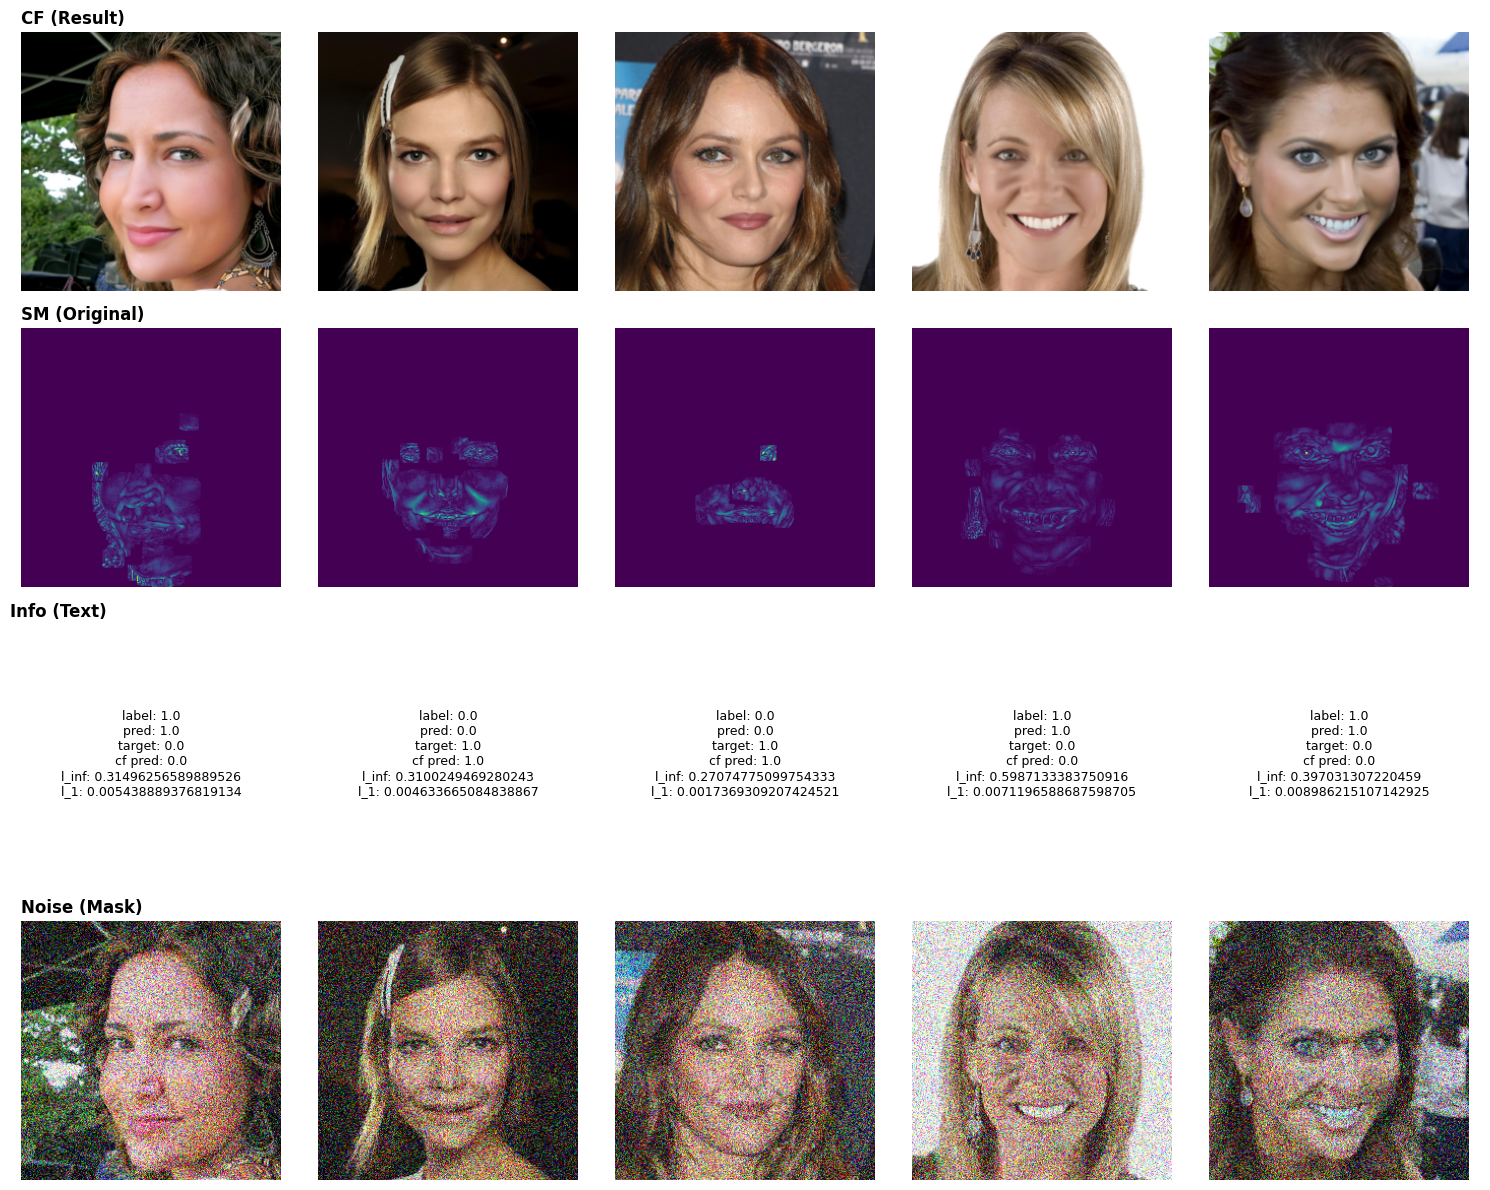

In [ ]:
results_path = os.path.join(workstation, "Results", "Results_Og1")
ace_visualization(results_path)

## My.1
- 여자 연예인 5명의 웃는 얼굴을 정색으로 바꾸는 설명 출력하기
    1) train/val/test 세트를 a/b+(c-5)/5 비율로 변경
    2) 혹은 guided_diffusion/image_dataset.py파일에서 샘플 선택을 고정
    - `T=-1`


## 파일 종속성 해결

In [ ]:
# import os
# import pandas as pd


# target_docs_dir = "/content/drive/MyDrive/Colab_Notebooks/ACE/CCKSY"



#     files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
#     num_images = len(files)


#     print("running: list_eval_partition.csv 생성 중...")

#     df_partition = pd.DataFrame({
#         'image_id': files,
#         'partition': [2] * num_images  # 2 = Test set
#     })

#     csv_part_path = os.path.join(image_dir, "list_eval_partition.csv")
#     df_partition.to_csv(csv_part_path, index=False)
#     # 포맷: image_id,attr1,attr2,...
#     print("running: list_attr_celeba.csv 생성 중...")

#     attr_columns = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young".split()

#     df_attr = pd.DataFrame(index=range(num_images), columns=['image_id'] + attr_columns)
#     df_attr['image_id'] = files

#     for col in attr_columns:
#         df_attr[col] = -1

#     csv_attr_path = os.path.join(image_dir, "list_attr_celeba.csv")
#     df_attr.to_csv(csv_attr_path, index=False)

#     mapping_path = os.path.join(image_dir, "CelebA-HQ-to-CelebA-mapping.txt")
#     with open(mapping_path, "w") as f:
#         f.write("idx        orig_idx   orig_file\n")
#         for idx, fname in enumerate(files):
#             f.write(f"{idx:<10} {idx:<10} {fname}\n")


#     attr_header_str = " ".join(attr_columns)
#     dummy_labels_str = " ".join(["-1"] * 40)

#     anno_path = os.path.join(image_dir, "CelebAMask-HQ-attribute-anno.txt")
#     with open(anno_path, "w") as f:
#         f.write(f"{num_images}\n")
#         f.write(f"{attr_header_str}\n")
#         for fname in files:
#             f.write(f"{fname} {dummy_labels_str}\n")

# create_csv_dependency_files(target_docs_dir)

## My1.sh 출력

`!bash ./scripts/My1.sh`
```
Namespace(clip_denoised=True, batch_size=1, gpu='0', save_images=True, num_samples=5, cudnn_deterministic=False, model_path='/content/drive/MyDrive/Colab_Notebooks/ACE/celebahq-ddpm.pt', classifier_path='/content/drive/MyDrive/Colab_Notebooks/ACE/decision_densenet/celebamaskhq/checkpoint.tar', output_path='/content/drive/MyDrive/Colab_Notebooks/ACE', exp_name='experiment_name', seed=4, attack_method='PGD', attack_iterations=50, attack_epsilon=255, attack_step=1.0, attack_joint=True, attack_joint_checkpoint=False, attack_checkpoint_backward_steps=1, attack_joint_shortcut=False, dist_l1=0.001, dist_l2=0.0, dist_schedule='none', sampling_time_fraction=0.2, sampling_stochastic=True, sampling_inpaint=0.15, sampling_dilation=15, label_query=31, label_target=-1, image_size=256, data_dir='/content/drive/MyDrive/Colab_Notebooks/ACE/CCKSY', dataset='CelebAHQ', chunks=1, chunk=0, merge_chunks=False, num_channels=128, num_res_blocks=2, num_heads=4, num_heads_upsample=-1, num_head_channels=64, attention_resolutions='32,16,8', channel_mult='', dropout=0.0, class_cond=False, use_checkpoint=False, use_scale_shift_norm=True, resblock_updown=True, use_fp16=True, use_new_attention_order=False, learn_sigma=True, diffusion_steps=500, noise_schedule='linear', timestep_respacing='25', use_kl=False, predict_xstart=False, rescale_timesteps=False, rescale_learned_sigmas=False)
Slow route. This may take some time!
Images on the dataset: 5
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loading Model and diffusion model
Loading Classifier
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Loading PGD
Starting Image Generation
[Chunks (0+1) / 1] 0 / 5 | Time: 0s
[Chunks (0+1) / 1] 1 / 5 | Time: 51s
[Chunks (0+1) / 1] 2 / 5 | Time: 99s
[Chunks (0+1) / 1] 3 / 5 | Time: 148s
[Chunks (0+1) / 1] 4 / 5 | Time: 197s
[Chunks (0+1) / 1] 5 / 5 | Time: 247s

Done
==================================================
Results:


n: 5
clean acc: 1.0
clean acc5: 1.0
explanation:
  cf: 1.0
  cf5: 1.0
  untargeted: 1.0
  untargeted5: 0.0
  l1: 0.004964319756254554
  l inf: 0.4759055316448212
pre-explanation:
  cf: 1.0
  cf5: 1.0
  untargeted: 1.0
  untargeted5: 0.0
  l1: 0.0014357467647641898
  l inf: 0.17568626999855042
==================================================
```

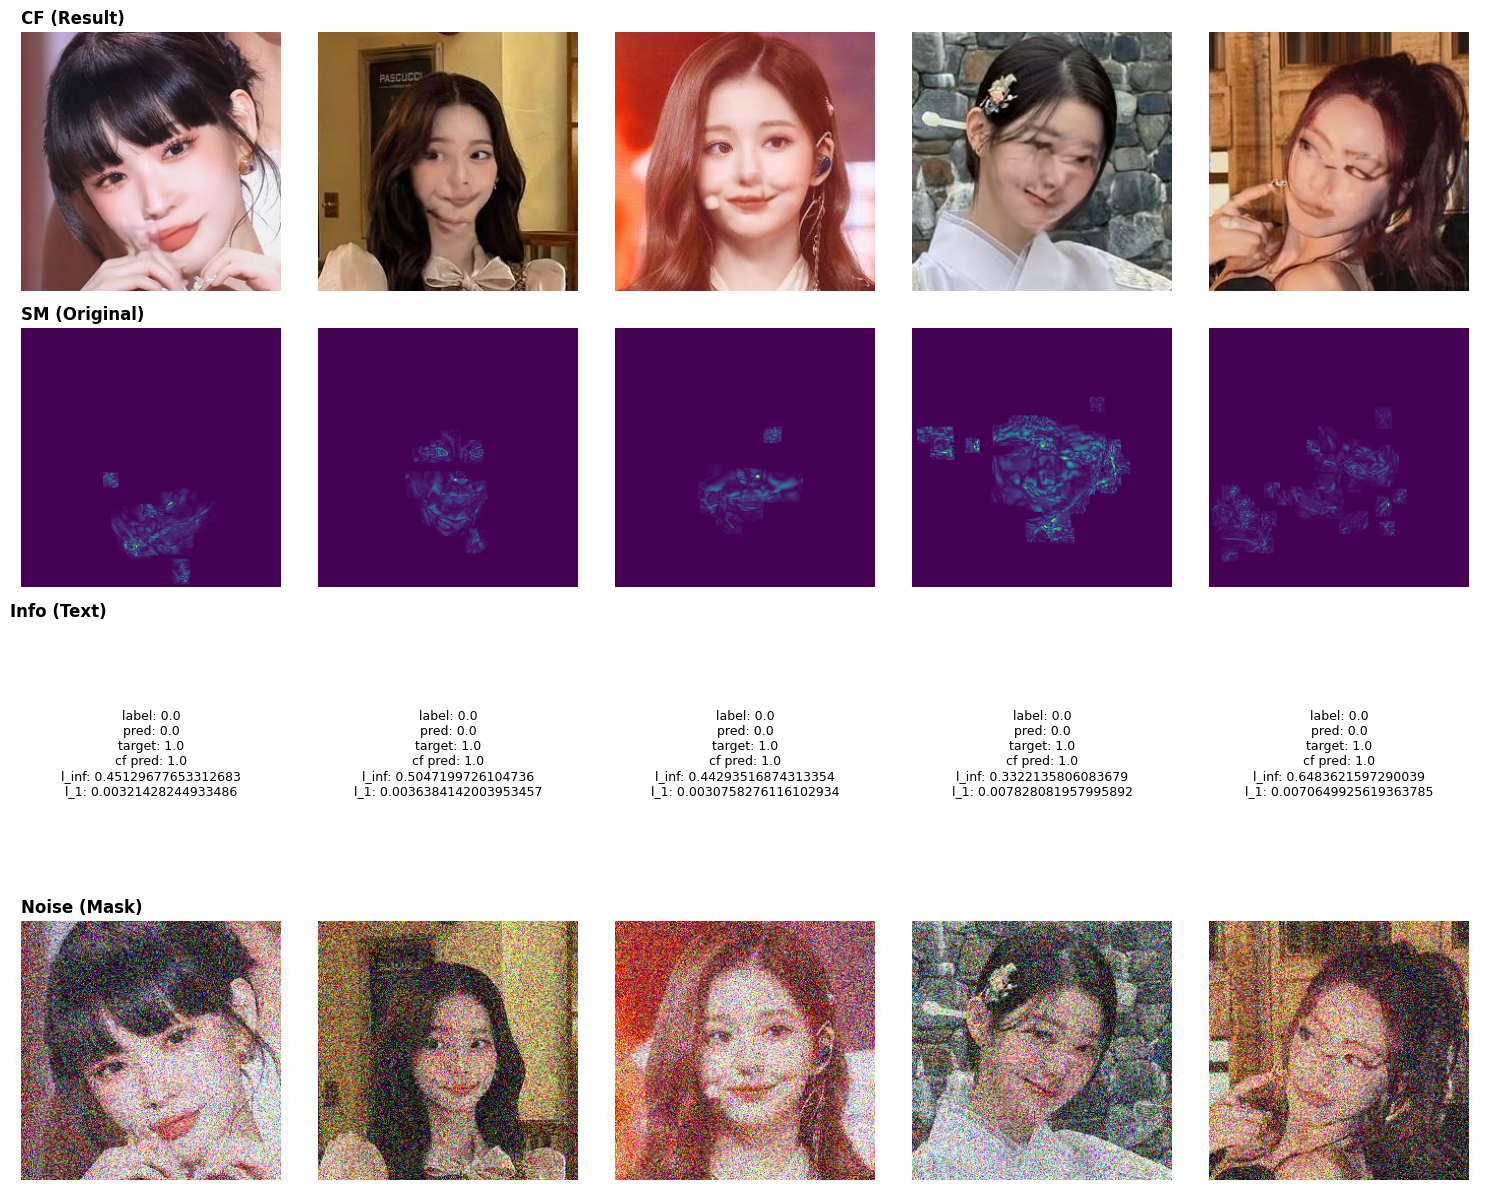

In [ ]:
results_path = os.path.join(workstation, "Results", "Results_My1")
ace_visualization(results_path)